## **Predictive modeling - Random forest regressor model (Daily mean tempreture - Kandy)**

In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
kandy_weather = pd.read_csv('../data/processed/kandy_weather_cleaned.csv', index_col=0, parse_dates=['time'])

In [3]:
#drop highly correlated columns 
kandy_weather = kandy_weather.drop(columns=['apparent_temperature_mean'])

In [4]:

# --- Define features and target ---
numerical_vars = ['shortwave_radiation', 'rainfall', 'max_wind_speed', 
                  'max_wind_gust', 'dominant_Wind_Direction', 'evapotranspiration', 'rain_tomorrow', 'year', 'month']  
categorical_vars = ['weathercode'] 
target = 'mean_temperature'

# --- One-hot encode categorical variables using get_dummies ---
columns_to_use = categorical_vars + numerical_vars + [target]
kandy_weather_dummies = pd.get_dummies(kandy_weather[columns_to_use],
                                       columns=categorical_vars,
                                       drop_first=True)

# Features (after encoding categorical variables)
X = kandy_weather_dummies.drop(columns=target)
y = kandy_weather_dummies[target]

# Example: chronological split
train_set = kandy_weather_dummies[kandy_weather_dummies['year'] <= 2018]
validation_set = kandy_weather_dummies[kandy_weather_dummies['year'] == 2019]
test_set = kandy_weather_dummies[kandy_weather_dummies['year'] >= 2020]

x_train = train_set.drop(columns=target)
y_train = train_set[target]

x_val = validation_set.drop(columns=target)
y_val = validation_set[target]

x_test = test_set.drop(columns=target)
y_test = test_set[target]


In [5]:
# Initialize the model
rf_model = RandomForestRegressor(
    n_estimators=200,      # number of trees
    max_depth=None,        # let trees expand fully
    random_state=42,       # reproducibility
    n_jobs=-1              # use all CPU cores
)

# Train
rf_model.fit(x_train, y_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [6]:
# Predictions
y_val_pred = rf_model.predict(x_val)
y_test_pred = rf_model.predict(x_test)

# Metrics
mse = mean_squared_error(y_val, y_val_pred)
rmse = mse ** 0.5
r2 = r2_score(y_val, y_val_pred)


print("Validation RMSE:", rmse)
print("Validation R²:", r2)

print("Test RMSE:", rmse)
print("Test R²:", r2_score(y_test, y_test_pred))

Validation RMSE: 0.6388550063810136
Validation R²: 0.7364142506889468
Test RMSE: 0.6388550063810136
Test R²: 0.7257300896776635


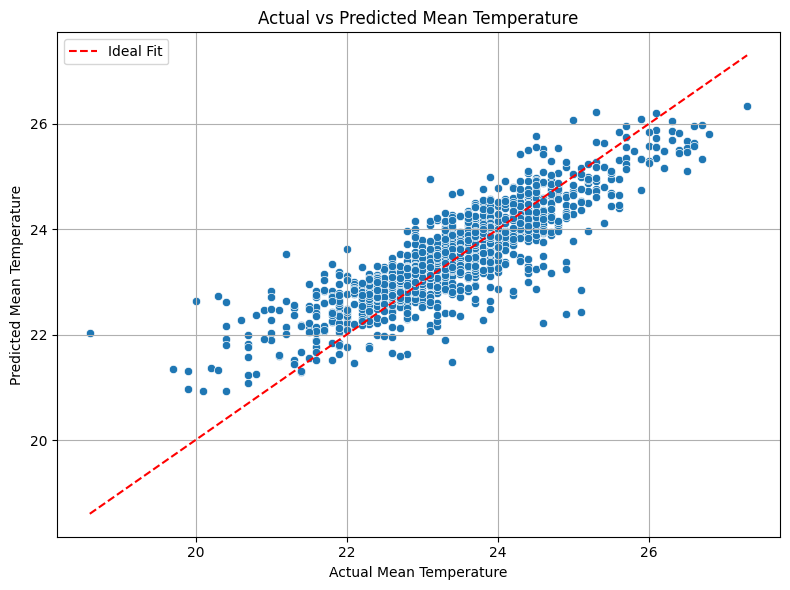

In [7]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Mean Temperature')
plt.ylabel('Predicted Mean Temperature')
plt.title('Actual vs Predicted Mean Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

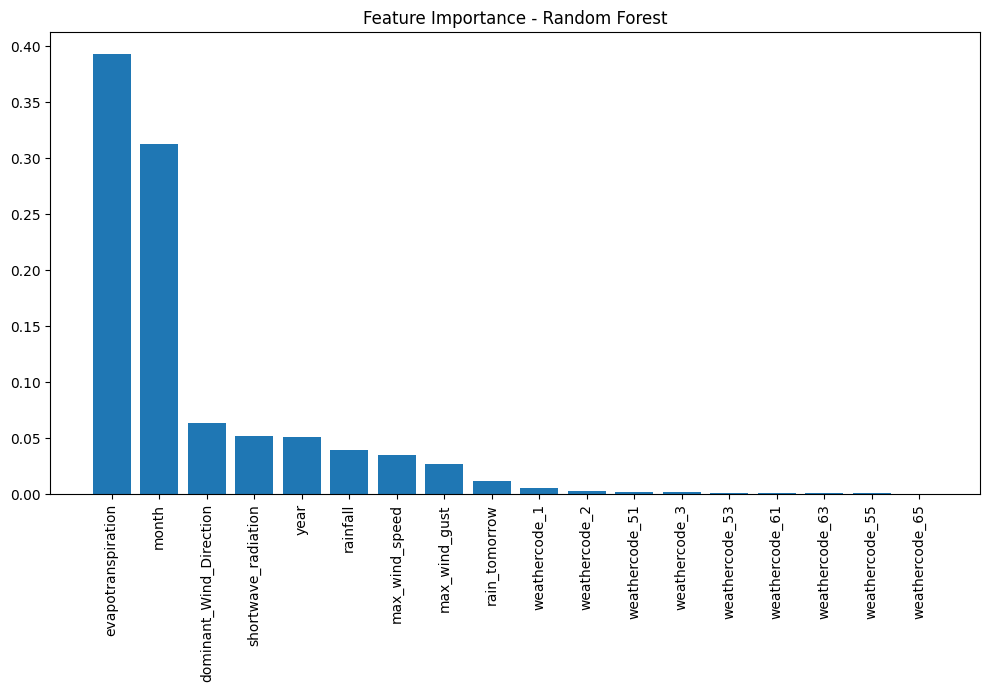

In [8]:
# Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.bar(range(x_train.shape[1]), importances[indices])
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
plt.title("Feature Importance - Random Forest")
plt.show()


### **hyperparameter tuning**

### **1. Grid Search**

In [9]:
# --- Hyperparameter Tuning with Randomized Search ---

param_grid = {
    'n_estimators': [100, 200, 300],         # number of trees
    'max_depth': [None, 10, 20, 30],         # tree depth
    'min_samples_split': [2, 5, 10],         # min samples to split
    'min_samples_leaf': [1, 2, 4],           # min samples per leaf
    'max_features': [None, 'sqrt', 'log2'] # number of features to consider
}



In [10]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=3,              # 3-fold cross validation
                           scoring='neg_mean_squared_error',
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score (MSE):", grid_search.best_score_)


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score (MSE): -0.39012196616903116


In [11]:
# from sklearn.ensemble import RandomForestRegressor

# best_rf = RandomForestRegressor(
#     n_estimators=100,
#     max_depth=30,
#     min_samples_split=2,
#     min_samples_leaf=2,
#     max_features=None,
#     random_state=42,
#     n_jobs=-1
# )

# # Combine training + validation set
# x_train_full = pd.concat([x_train, x_val])
# y_train_full = pd.concat([y_train, y_val])

# best_rf.fit(x_train_full, y_train_full)


In [12]:
best_rf_gs = grid_search.best_estimator_   # or grid_search.best_estimator_



y_val_pred_gs = best_rf_gs.predict(x_val)

mse = mean_squared_error(y_val, y_val_pred_gs)
rmse = np.sqrt(mse)   # manually calculate RMSE
r2 = r2_score(y_val, y_val_pred_gs)

print("Validation RMSE:", rmse)
print("Validation R²:", r2)




Validation RMSE: 0.6394915429351203
Validation R²: 0.7358887306587769


In [13]:

# --- Retrain best model on training + validation ---
best_params_gs = grid_search.best_params_

final_model_gs = RandomForestRegressor(**best_params_gs, random_state=42, n_jobs=-1)

# Combine train and validation sets
X_train_val = pd.concat([x_train, x_val])
y_train_val = pd.concat([y_train, y_val])

final_model_gs.fit(X_train_val, y_train_val)


,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
# --- Final evaluation on test set ---
y_test_pred_gs = final_model_gs.predict(x_test)

mse = mean_squared_error(y_test, y_test_pred_gs)
rmse = mse ** 0.5

r2 = r2_score(y_test, y_test_pred_gs)


print("Final Test RMSE:", rmse)
print("Final Test R²:", r2)

Final Test RMSE: 0.6709444158757067
Final Test R²: 0.6435911039708899


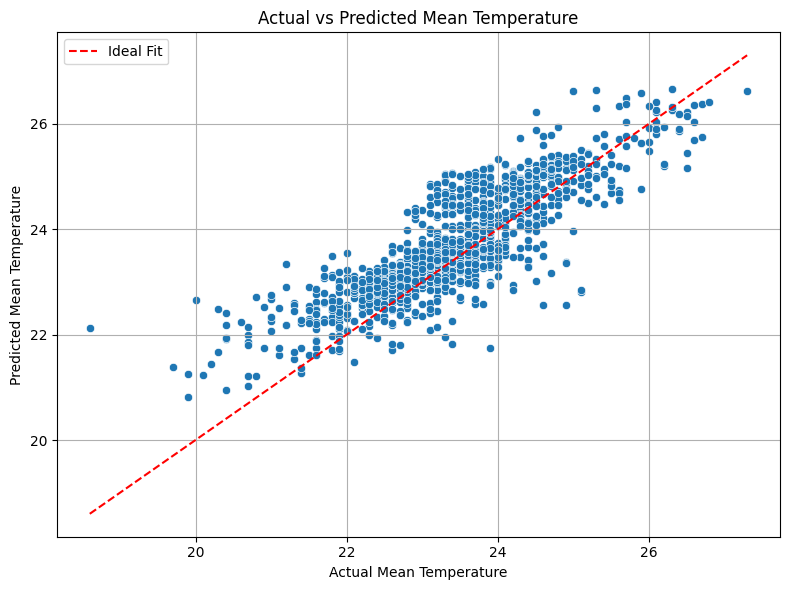

In [15]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred_gs)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Mean Temperature')
plt.ylabel('Predicted Mean Temperature')
plt.title('Actual vs Predicted Mean Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **2. Randomized search**

In [16]:
param_dist = {
    'n_estimators': [100, 200, 400, 600, 800, 1000],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

In [17]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_dist,
                                   n_iter=50,       # number of random combos to try
                                   cv=3,
                                   scoring='neg_mean_squared_error',
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

random_search.fit(x_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score (MSE):", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None}
Best Score (MSE): -0.3899421325171153


In [18]:
best_rf_rs = random_search.best_estimator_   # or grid_search.best_estimator_
y_val_pred_rs = best_rf_rs.predict(x_val)

mse = mean_squared_error(y_val, y_val_pred_rs)
rmse = np.sqrt(mse)   # manually calculate RMSE
r2 = r2_score(y_val, y_val_pred_rs)


print("Validation RMSE:", rmse)
print("Validation R²:", r2)


Validation RMSE: 0.6357427819459003
Validation R²: 0.7389761460678124


In [19]:
# --- Retrain best model on training + validation ---
best_params_rs = random_search.best_params_

final_model_rs = RandomForestRegressor(**best_params_rs, random_state=42, n_jobs=-1)

# Combine train and validation sets
X_train_val = pd.concat([x_train, x_val])
y_train_val = pd.concat([y_train, y_val])

final_model_rs.fit(X_train_val, y_train_val)

,n_estimators,1000
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
y_test_pred_rs = final_model_rs.predict(x_test)

mse = mean_squared_error(y_test, y_test_pred_rs)
rmse = np.sqrt(mse)   # manually calculate RMSE
r2 = r2_score(y_test, y_test_pred_rs)

print("Final Test RMSE:", rmse)
print("Final Test R²:", r2)


Final Test RMSE: 0.665548901207156
Final Test R²: 0.6493003021579289


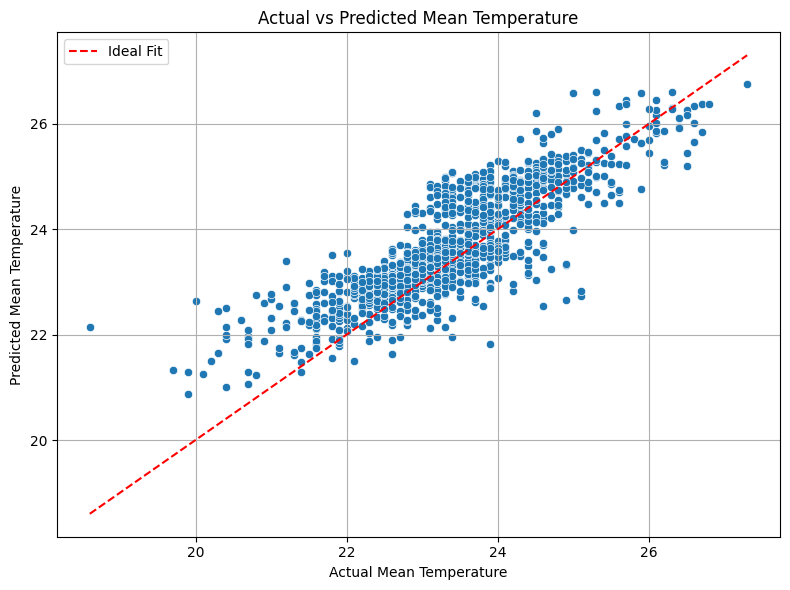

In [21]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred_rs)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Mean Temperature')
plt.ylabel('Predicted Mean Temperature')
plt.title('Actual vs Predicted Mean Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Residual Analysis after grid search**

In [22]:
residuals = y_test - y_test_pred_gs

In [23]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(residuals)
print(f"Durbin–Watson Statistic: {dw_stat:.4f}")


Durbin–Watson Statistic: 0.5175


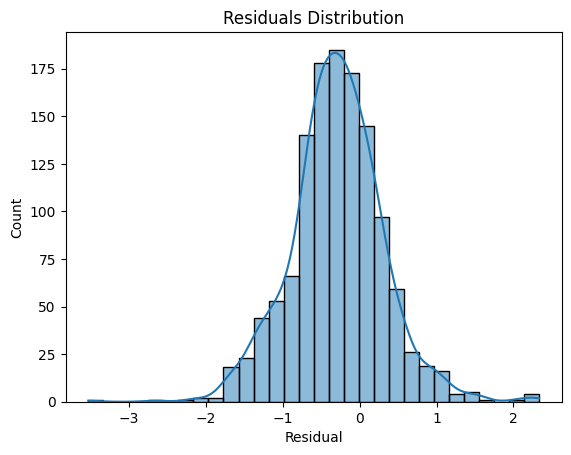

In [24]:
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.show()


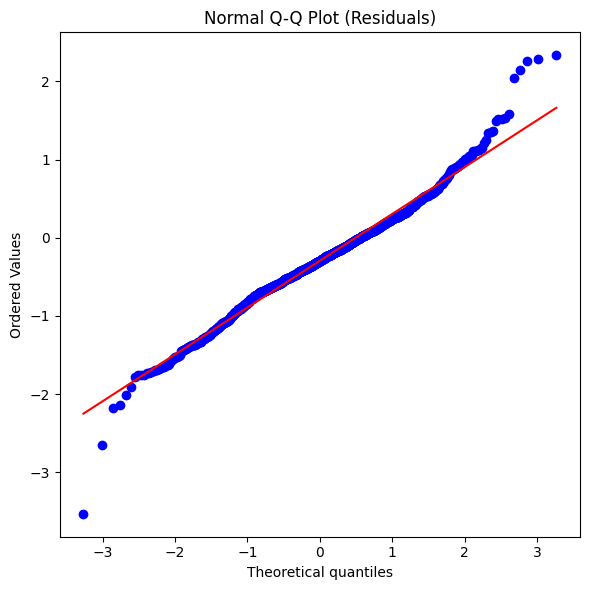

In [25]:
from scipy.stats import probplot

plt.figure(figsize=(6, 6))
probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot (Residuals)')
plt.tight_layout()
plt.show()

In [26]:
from scipy.stats import shapiro
stat, p = shapiro(residuals)
print("Shapiro-Wilk Test: stat=%.3f, p=%.3f" % (stat, p))

Shapiro-Wilk Test: stat=0.983, p=0.000


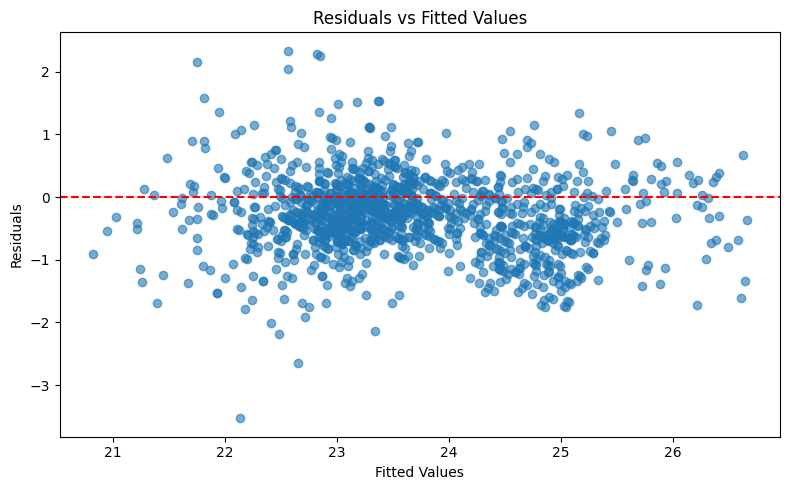

In [27]:

plt.figure(figsize=(8, 5))
plt.scatter(y_test_pred_gs, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.tight_layout()
plt.show()

In [28]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Requires residuals & design matrix
import statsmodels.api as sm


# Compute z-scores for residuals
z_scores = (residuals - np.mean(residuals)) / np.std(residuals)
mask = np.abs(z_scores) <= 3   # True = keep

# Apply mask to residuals and x_test
residuals_clean = residuals[mask]
x_test_clean = x_test[mask]

# Add intercept to cleaned x_test
exog = sm.add_constant(x_test_clean)

# Run Breusch-Pagan test
bp_test = het_breuschpagan(residuals_clean, exog)

print("\n--- Breusch-Pagan Test ---")
print(f"Test Statistic: {bp_test[0]:.4f}")
print(f"p-value       : {bp_test[1]:.4f}")



--- Breusch-Pagan Test ---
Test Statistic: 154.9321
p-value       : 0.0000


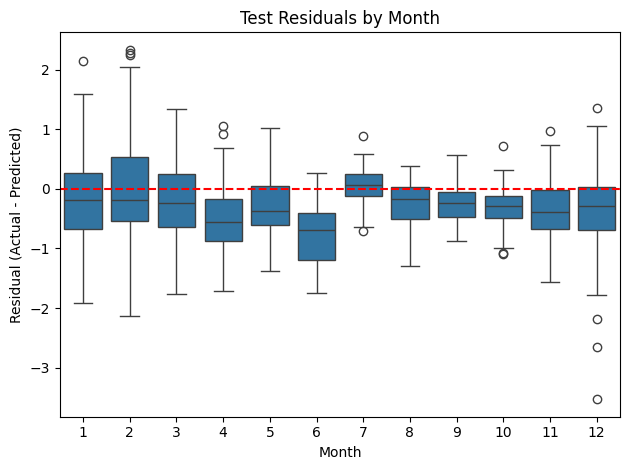

In [29]:
# Residual vs Month (seasonality)

sns.boxplot(x=x_test["month"], y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.title("Test Residuals by Month")
plt.xlabel("Month")
plt.ylabel("Residual (Actual - Predicted)")

plt.tight_layout()
plt.show()
